<a href="https://colab.research.google.com/github/Kyotaro65/Used_Cars_Price_Prediction/blob/wide_pca_xgb/Used_Cars_Price_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Used Cars Price Prediction

##準備

###インポートなど

In [871]:
#これを実行して指示に従い、ドライブをマウントしてください
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [872]:
#必要なモジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [873]:
#train-data.csvのパスを作るための処理
path=!find / -name 'Used_Cars_Price_Prediction'
print(path[-1])

/content/drive/MyDrive/github/Used_Cars_Price_Prediction


### データの読み込みと確認

データの取得元はkaggle上の以下のページです。

https://www.kaggle.com/avikasliwal/used-cars-price-prediction

In [874]:
#CSVファイルをpandas.DataFrameにします。
df=pd.read_csv(path[-1]+'/train-data.csv')
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


上記のように、行が各中古車を表し、列にはその中古車の各データが書かれています。

もし、上のデータ読み込みがうまくいかない場合は画面の左側のフォルダアイコンをクリックし、

drive>MyDrive>...

と開いていってUsed_Cars_Price_Predictionフォルダ内のtrain-data.csvファイルを見つけてください。これを右クリックし、「パスをコピー」を選んで下記のコードの1行目の(' ')の中に張り付けてください。

df=pd.read_csv('/content/drive/MyDrive/.../Used_Cars_Price_Prediction/train-data.csv')

という形にして、2行ともコメントアウト(#)を外して実行してください。

In [875]:
#df=pd.read_csv('')
#df.head()

In [876]:
#列の一覧を確認
df.columns

Index(['Unnamed: 0', 'Name', 'Location', 'Year', 'Kilometers_Driven',
       'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
       'Seats', 'New_Price', 'Price'],
      dtype='object')

各列は、行番号　,　車種名　,　中古車の所在地(インド国内の地域)　,　年(西暦)　　 総走行距離(km)　,　燃料の種類　,　マニュアルまたはオートマ　,　前オーナー人数　,　燃費(km/Lまたはkm/kg)　,　排気量(cc)　,　馬力(bhp)　,　席数　,　値段(十万インド・ルピー≓14万円)　を表しています。

各列(各特徴量)の説明は[kaggle上のページ](https://www.kaggle.com/avikasliwal/used-cars-price-prediction)に記載してあります。

まず、'Unnamed: 0'の列はその行の番号を表しているだけなので切り落とします。

In [877]:
df=df.drop(columns='Unnamed: 0')

In [878]:
#(行数,列数)を確認
df.shape

(6019, 13)

In [879]:
#データの型と欠損値を確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


##前処理

###欠損値の処理
欠損値となっているデータをどう扱うか決めていきます。

In [880]:
#各列で、欠損値の数を数えます
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

'New_Price'の列は欠損値が多すぎて意味をなさないのでこの列を切り落とします。

In [881]:
df=df.drop(columns='New_Price')

'Mileage','Engine','Power','Seats'の列は欠損値がそれほど多くないので、欠損値を含む行をすべて削除してしまいます。

In [882]:
df=df.dropna()
df.shape

(5975, 12)

In [883]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5975 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5975 non-null   object 
 1   Location           5975 non-null   object 
 2   Year               5975 non-null   int64  
 3   Kilometers_Driven  5975 non-null   int64  
 4   Fuel_Type          5975 non-null   object 
 5   Transmission       5975 non-null   object 
 6   Owner_Type         5975 non-null   object 
 7   Mileage            5975 non-null   object 
 8   Engine             5975 non-null   object 
 9   Power              5975 non-null   object 
 10  Seats              5975 non-null   float64
 11  Price              5975 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 606.8+ KB


In [884]:
df.isnull().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

これで欠損値がなくなったことが確認できました。

### 各列を使用可能な数値データに変換

#### 'Owner_Type'について


'Owner_Type'は、[kaggle上のページ](https://www.kaggle.com/avikasliwal/used-cars-price-prediction)の説明より、前のオーナーの数を表します。

序数で書かれているので、First,Second,...を、数値型の1,2,...に変換します。

まず、どんな値を取っているのか調べます。

In [885]:
df['Owner_Type'].value_counts()

First             4903
Second             953
Third              111
Fourth & Above       8
Name: Owner_Type, dtype: int64

取る値とその回数が確認できたので、First,Second,Third,Fourth & Aboveを、それぞれ1,2,3,4に変換することにします。

数値は整数型にします。



In [886]:
df['Owner_Type'] = df['Owner_Type'].str.replace('First','1').replace('Second','2').replace('Third','3').replace('Fourth & Above','4')
df['Owner_Type'] = df['Owner_Type'].astype(int)
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,1,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,1,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,1,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,1,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


####'Mileage'について
0行目は単位km/kgで、1～4行目はkmplつまりkm/Lで書かれていることが確認できます。

まず、それぞれの単位で書かれたデータの数を数えます。

In [887]:
kmpkg=0
kmpl=0
other_mi=0
for i in df['Mileage']:
    if str(i).endswith(" km/kg"):
      kmpkg+=1
    elif str(i).endswith(" kmpl"):
      kmpl+=1
    else:
      other_mi+=1

print("km/kgで書かれたデータは",kmpkg,"コ")
print("km/Lで書かれたデータは",kmpl,"コ")
print("それ以外の単位で書かれたデータは",other_mi,"コ")

km/kgで書かれたデータは 66 コ
km/Lで書かれたデータは 5909 コ
それ以外の単位で書かれたデータは 0 コ


燃費の単位は燃料の種類によって違うことが考えられるので、まずデータ全体で各燃料種類の車の数を数えます。

In [888]:
df['Fuel_Type'].value_counts()

Diesel    3195
Petrol    2714
CNG         56
LPG         10
Name: Fuel_Type, dtype: int64

次に燃費の単位ごとに各燃料種類の車の数を数えます。

In [889]:
df_kmpkg=df.query('Mileage.str.endswith("km/kg")',engine='python')
df_kmpl=df.query('Mileage.str.endswith("kmpl")',engine='python')

print("km/kgで書かれた中古車の燃料種類")
print(df_kmpkg['Fuel_Type'].value_counts())
print("-----------------------------------")
print("km/Lで書かれた中古車の燃料種類")
print(df_kmpl['Fuel_Type'].value_counts())

km/kgで書かれた中古車の燃料種類
CNG    56
LPG    10
Name: Fuel_Type, dtype: int64
-----------------------------------
km/Lで書かれた中古車の燃料種類
Diesel    3195
Petrol    2714
Name: Fuel_Type, dtype: int64


km/kgで書かれているのはCNGとLPGの車

㎞/Lで書かれているのは軽油とガソリンの車

とわかります。





##### 'Mileage'の単位換算
Petrol: 0.9\$/L , Diesel: 1.0\$/L , CNG: 1.5\$/kg , LPG: 1.5\$/kg

全てを一律に比べるため、今回は燃料1USドル分で走れる距離(km/\$)を燃費の単位とします。

そのために各燃料の単価を求めます。

'Location'から分かる通りインドの市場、[データの更新時期は2019年](https://www.kaggle.com/avikasliwal/used-cars-price-prediction)なので、

今回、2019年のガソリンと自動車用軽油にはインドの価格を用います。

2019/12/09時点で1L当たりガソリンは75ルピー、軽油は66.04ルピーで、当時のレート(1ルピー=0.014USD)から、それぞれ1.0\$/L,0.9\$/Lです。


CNGとLPGはインドの価格に関する資料が見つからなかったので、国内の小売価格を参考にします。

<br>

*   ガソリン(Petrol): 1.0 \$/L
*   自動車用軽油(Diesel): 0.9 \$/L
*   圧縮天然ガス(CNG): 1.5 \$/kg
*   液化石油ガス(オートガス,LPG): 1.5 \$/kg

<br>
(説明)


CNGはメタン(ガス密度約0.7kg/m³)を主成分とした天然ガスを20MPaで圧縮したものです。

価格は105円/m³(標準状態) , ガス密度は標準状態でメタンと同じ0.7kg/m³として、

150円/kg ≓ 1.5\$/kg

<br>

LPG(オートガス)はブタン(液密度約580kg/m³)が主成分です。

価格は86円/L , 液密度は580kg/m³ , 1m³=1000L として、

約148円/kg ≓ 1.5\$/kg

<br>

######参考文献



  










1. NNA ASIA   アジア経済ニュース

  ガソリンが75ルピーに値上がり、１年ぶり (2019/12/11（水）)
  
  https://www.nna.jp/news/show/1984842

  [アクセス日: 2021/01/30]

2.   大阪ガス

  天然ガス自動車＞CNG基本単価

  https://ene.osakagas.co.jp/product/ngv/users/cng_price.html

  [アクセス日: 2021/01/30]

3.  国際石油開発帝石

  天然ガスの成分構造

  https://www.inpex.co.jp/museum/01/02.html

  [アクセス日: 2021/01/30]

4.  JOGMEC 独立行政法人石油天然ガス・金属鉱物資源機構

  石油・天然ガス資源情報

  圧縮天然ガス

  https://oilgas-info.jogmec.go.jp/termlist/1000201/1000216.html

  [アクセス日: 2021/01/30]
　
5.  日本LPガス協会

  LPガスの概要＞LPガスの性質

  https://www.j-lpgas.gr.jp/intr/seishitsu.html

  [アクセス日: 2021/01/30]

6. 財団法人 日本エネルギー経済研究所 石油情報センター

  価格情報＞オートガス

  https://oil-info.ieej.or.jp/price/price.html

  https://oil-info.ieej.or.jp/price/data/autogas.xls

  [アクセス日: 2021/01/30]

7. JPH10121069A - オートガス組成物 - Google Patents

  https://patents.google.com/patent/JPH10121069A/ja

  [アクセス日: 2021/01/30]

##### 'Mileage'の値の書き換え

In [890]:
#以下の4値を書き換えると各燃料の単価を変更できます。
pet_dpl=1.0
die_dpl=0.9
cng_dpkg=1.5
lpg_dpkg=1.5
#国内のみでも試算

'Mileage'から単位表記を消し、さらに数値として扱うため浮動小数点型に変換したものを、新たに'Mileage_flo'列として加えます。

In [891]:
df['Mileage_flo'] = df['Mileage'].str.replace(' kmpl','')
df['Mileage_flo'] = df['Mileage_flo'].str.replace(' km/kg','')
df['Mileage_flo'] = df['Mileage_flo'].astype(float)
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Mileage_flo
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,1,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75,26.60
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,1,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50,19.67
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,1,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50,18.20
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,1,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00,20.77
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74,15.20


変換してしまう前に外れ値がないか確認します。

In [892]:
df['Mileage_flo'].describe()

count    5975.000000
mean       18.179408
std         4.521801
min         0.000000
25%        15.200000
50%        18.160000
75%        21.100000
max        33.540000
Name: Mileage_flo, dtype: float64

最小値が0になっているのが異常です。0となっている車の数を数えます。

In [893]:
zero_cou=0
a=[]
for i in df['Mileage_flo']:
  if i==0:
    zero_cou+=1

print(zero_cou)

56


0の車を除いて調べます。

In [894]:
df_not_m0=df[df['Mileage_flo']>0]
df_not_m0['Mileage_flo'].describe()

count    5919.000000
mean       18.351404
std         4.181298
min         6.400000
25%        15.300000
50%        18.200000
75%        21.100000
max        33.540000
Name: Mileage_flo, dtype: float64

'Mileage'が0となっている車を除けば異常はなさそうです。
'Mileage'が0となっているのはデータが取れないほど走行距離が短い可能性などが考えられるので、その車の走行距離を調べます。

In [895]:
df_m0=df[df['Mileage_flo']==0]
df_m0['Kilometers_Driven'].value_counts()


70000     4
85000     2
58000     2
120000    2
119203    1
42021     1
75000     1
58163     1
46000     1
67000     1
105000    1
53000     1
89000     1
87591     1
20000     1
24720     1
27833     1
93000     1
63000     1
139000    1
4000      1
60170     1
15369     1
13190     1
227000    1
45500     1
69000     1
200000    1
65400     1
26000     1
74483     1
22769     1
54000     1
167000    1
20842     1
72000     1
33000     1
65000     1
82000     1
103000    1
8682      1
61449     1
66000     1
99000     1
51019     1
125000    1
215750    1
35268     1
50243     1
96000     1
Name: Kilometers_Driven, dtype: int64

走行距離に特に異常はなさそうなので、単純に'Mileage'を取得できなかった、つまり欠損値と見ることにします。

車種によってある程度'Mileage'は定まると考えられるます。'Mileage'が0となっている車と、'Mileage'が0となっていない車の間で、共通する車種ががないかどうか調べます。

In [896]:
m0_name_list=df_m0['Name'].unique().tolist()
print(m0_name_list)
df_m0name=df_not_m0[df_not_m0['Name'].isin(a)]
df_m0name.shape

['Land Rover Freelander 2 TD4 SE', 'Mercedes-Benz C-Class Progressive C 220d', 'Hyundai Santro Xing XL', 'Volkswagen Jetta 2007-2011 1.9 L TDI', 'Hyundai Santro GLS I - Euro I', 'Mercedes-Benz New C-Class Progressive C 200', 'Hyundai Santro LS zipPlus', 'Hyundai Santro Xing XP', 'Mercedes-Benz M-Class ML 350 4Matic', 'Smart Fortwo CDI AT', 'Hyundai Santro Xing GL', 'Land Rover Freelander 2 TD4 S', 'Hyundai Santro GLS I - Euro II', 'Maruti Baleno Vxi', 'Hyundai Santro DX', 'Mahindra Jeep MM 550 PE', 'Toyota Qualis RS E2', 'Hyundai Santro AT', 'Skoda Superb 3.6 V6 FSI', 'Hyundai Santro GS', 'Audi A7 2011-2015 Sportback', 'Hyundai Santro GS zipDrive - Euro II', 'Fiat Siena 1.2 ELX', 'Land Rover Freelander 2 TD4 HSE', 'Hyundai Santro LP - Euro II', 'Toyota Qualis Fleet A3', 'Mahindra Jeep MM 540 DP']


(0, 13)

上記のdf_m0nameが0行である、つまり共通する車種は1つもないので、今回は、'Mileage'が欠損値0となっているものは埋めずに、その行ごと削除してしまいます。

In [897]:
df=df_not_m0

'Mileage_kmpd'列の値について、燃料種類ごとに、km/\$単位の燃費に変換します。

In [898]:
for i in df.index:
  if df.at[i,'Fuel_Type']=='Petrol':
    df.at[i,'Mileage_kmpd']=df.at[i,'Mileage_flo']/pet_dpl
  elif df.at[i,'Fuel_Type']=='Diesel':
    df.at[i,'Mileage_kmpd']=df.at[i,'Mileage_flo']/die_dpl
  elif df.at[i,'Fuel_Type']=='CNG':
    df.at[i,'Mileage_kmpd']=df.at[i,'Mileage_flo']/cng_dpkg
  elif df.at[i,'Fuel_Type']=='LPG':
    df.at[i,'Mileage_kmpd']=df.at[i,'Mileage_flo']/pet_dpl
  else:
    print(i+"行目の車はその他の燃料を用いています!!")

df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Mileage_flo,Mileage_kmpd
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,1,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75,26.60,17.733333
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,1,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50,19.67,21.855556
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,1,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50,18.20,18.200000
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,1,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00,20.77,23.077778
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74,15.20,16.888889


'Mileage_kmpd'列が正しく追加できているのが確認できます。
不要になった'Mileage'と'Mileage_flo'を削除します。

In [899]:
df=df.drop(columns=['Mileage','Mileage_flo'])

####'Engine'について

単位が統一されているか確認します。

In [900]:
cc=0
other_en=0
for i in df['Engine']:
    if str(i).endswith(" CC"):
      cc+=1
    else:
      other_en+=1

print("bhpで書かれたデータは",cc,"コ")
print("それ以外の単位で書かれたデータは",other_en,"コ")

bhpで書かれたデータは 5919 コ
それ以外の単位で書かれたデータは 0 コ


単位はccのみで書かれているので、そのまま単位のみ切り落とします。

In [901]:
df['Engine'] = df['Engine'].str.replace(' CC','')
df['Engine'] = df['Engine'].astype(float)
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,1,998.0,58.16 bhp,5.0,1.75,17.733333
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,1,1582.0,126.2 bhp,5.0,12.50,21.855556
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,1,1199.0,88.7 bhp,5.0,4.50,18.200000
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,1,1248.0,88.76 bhp,7.0,6.00,23.077778
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2,1968.0,140.8 bhp,5.0,17.74,16.888889


####'Power'について

欠損値の削除の際には欠損値として検出されませんでしたが、'Power'の値がnull bhpとなっているところが確認できます。また、単位も統一されているかどうか確認します。

In [902]:
null_bhp=0
bhp=0
other_po=0
for i in df['Power']:
  if str(i)=="null bhp":
    null_bhp+=1
  elif str(i).endswith(" bhp"):
      bhp+=1
  else:
      other_po+=1

print("null bhpは",null_bhp,"コ")
print("bhpで書かれたデータは",bhp,"コ")
print("それ以外の単位で書かれたデータは",other_po,"コ")

null bhpは 75 コ
bhpで書かれたデータは 5844 コ
それ以外の単位で書かれたデータは 0 コ


単位はbhpのみで書かれているので、そのまま単位を切り落とします。

ちなみに、1bhp(英馬力)=1.013PS(仏馬力)=745W=641kcal/h

In [903]:
df['Power'] = df['Power'].str.replace(' bhp','')
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,1,998.0,58.16,5.0,1.75,17.733333
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,1,1582.0,126.2,5.0,12.50,21.855556
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,1,1199.0,88.7,5.0,4.50,18.200000
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,1,1248.0,88.76,7.0,6.00,23.077778
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2,1968.0,140.8,5.0,17.74,16.888889


#####null bhpの扱い

馬力は車種によってある程度定まると考えられるので、nullとなっている車の車種を調べます。

In [904]:
df_nullbhp=df[df['Power']=="null"]
print(df_nullbhp['Name'].value_counts())

Maruti Swift VDI BSIV                      11
Hyundai Santro Xing XL eRLX Euro III        7
Toyota Etios GD                             6
Toyota Etios Liva GD                        5
Hyundai Santro Xing XO                      5
Maruti Swift VDI BSIV W ABS                 5
Hyundai Santro Xing XO eRLX Euro II         5
Tata Indica DLS                             3
Mercedes-Benz E-Class 220 CDI               2
Hyundai Santro Xing XG eRLX Euro III        2
Ford Fiesta 1.4 SXi TDCi                    2
Toyota Etios Liva G                         2
Maruti Esteem Vxi                           2
Skoda Laura Classic 1.8 TSI                 1
Hyundai Santro Xing XO CNG                  1
Porsche Cayman 2009-2012 S tiptronic        1
Nissan Teana 230jM                          1
Maruti 1000 AC                              1
Nissan Micra Diesel                         1
Ford Fiesta 1.6 SXI ABS Duratec             1
Honda CR-V Sport                            1
Maruti Baleno LXI - BSIII         

このようにnullの多い車種もあるようです。

nullを最も多くもつ車種Maruti Swift VDI BSIVを例にとって、その車種全体での'Power'の値を見てみましょう。

In [905]:
df[df['Name']=="Maruti Swift VDI BSIV"]['Power'].value_counts()

74      20
null    11
Name: Power, dtype: int64

上記の例のように、同じ車種の中でも'Power'が入力されている行と欠損している行があります。

各車種でnullでない'Power'の平均値を取って埋め,
それによって埋まらないときはその行自体を削除しようと思います。

まず、　'Power'がnullである車の'Name'の配列、'Power、'Name''、データフレーム　を引数に渡せば、

車を車種ごとに分けてnull埋めに使う各平均値を算出し、nullを埋めてくれる関数を作ります。

In [906]:
def fill_null(name_array,df,colnull='Power',colname='Name'):

  for na in name_array:
    po_seri_each = df[(df[colname]==na) & (df[colnull]!="null")][colnull]  #'Power'がnullである車と車種が共通するが、'Power'がnullでない車たちの'Power'の値の配列
    po_seri_each = po_seri_each.astype(float)

    if len(po_seri_each)>0:  #「'Power'がnullである車と車種が共通するが、'Power'がnullでない車」が存在するとき
      ave = po_seri_each.mean()  #null埋めに用いる平均値
      null_index = df[(df[colname]==na) & (df[colnull]=="null")].index  #今回の車種で、'Power'がnullである車たちの行番号

      for i in null_index:
        df.at[i,colnull]=ave  #aveでnullを埋める作業

  return df

'Power'がnullである車の'Name'の配列　を作ります。

In [907]:
ponull_name_array=df_nullbhp['Name'].unique()

関数を呼び出し、null埋めを実行します。

In [908]:
df=fill_null(ponull_name_array,df)
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,1,998.0,58.16,5.0,1.75,17.733333
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,1,1582.0,126.2,5.0,12.50,21.855556
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,1,1199.0,88.7,5.0,4.50,18.200000
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,1,1248.0,88.76,7.0,6.00,23.077778
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2,1968.0,140.8,5.0,17.74,16.888889


残ったnullを確認します。

In [909]:
df_null=df[df['Power']=="null"]
print("残ったnullの数は",df_null.shape[0],"コ")
print("---------------------------------------------------------")
print(df_null['Name'].value_counts())

残ったnullの数は 50 コ
---------------------------------------------------------
Hyundai Santro Xing XL eRLX Euro III       7
Hyundai Santro Xing XO eRLX Euro II        5
Hyundai Santro Xing XO                     5
Maruti Swift VDI BSIV W ABS                5
Tata Indica DLS                            3
Hyundai Santro Xing XG eRLX Euro III       2
Maruti Esteem Vxi                          2
Ford Fiesta 1.4 SXi TDCi                   2
Mercedes-Benz E-Class 220 CDI              2
Skoda Laura Classic 1.8 TSI                1
Nissan Micra Diesel                        1
Maruti 1000 AC                             1
Hyundai Santro Xing XO CNG                 1
Porsche Cayman 2009-2012 S tiptronic       1
Nissan Teana 230jM                         1
Ford Fiesta 1.6 SXI ABS Duratec            1
Fiat Petra 1.2 EL                          1
Maruti Baleno LXI - BSIII                  1
Audi A4 3.2 FSI Tiptronic Quattro          1
Honda CR-V Sport                           1
Hyundai Santro Xing XL AT 

割と残ってしまいましたが、今回はこのままnullを埋められなかった行を削除します。

In [910]:
df=df[df['Power']!="null"]

#####'Power'の値を浮動小数点型に変換します。

In [911]:
df['Power'] = df['Power'].astype(float)
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,1,998.0,58.16,5.0,1.75,17.733333
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,1,1582.0,126.20,5.0,12.50,21.855556
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,1,1199.0,88.70,5.0,4.50,18.200000
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,1,1248.0,88.76,7.0,6.00,23.077778
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2,1968.0,140.80,5.0,17.74,16.888889


これで'Power'の列も使用可能な数値データに変換できました。

####'Name','Location'について

#####'Name'の処理

車種は無視して、メーカー('Name'の先頭)のみについて考えることにします。
まずは'Name'を半角スペースで分割してデータフレームdf_name_splitに格納します。

In [912]:
df_name_split=df['Name'].str.split(' ', expand=True)
print(df['Name'].head())
df_name_split.head()

0              Maruti Wagon R LXI CNG
1    Hyundai Creta 1.6 CRDi SX Option
2                        Honda Jazz V
3                   Maruti Ertiga VDI
4     Audi A4 New 2.0 TDI Multitronic
Name: Name, dtype: object


,0,1,2,3,4,5,6,7,8,9
0,Maruti,Wagon,R,LXI,CNG,None,None,None,None,None
1,Hyundai,Creta,1.6,CRDi,SX,Option,None,None,None,None
2,Honda,Jazz,V,None,None,None,None,None,None,None
3,Maruti,Ertiga,VDI,None,None,None,None,None,None,None
4,Audi,A4,New,2.0,TDI,Multitronic,None,None,None,None


正しく分割できていそうです。
df_name_splitの1列目がメーカーの情報を持つので、これをdfの新たな列'Manufacturer'として追加します。

In [913]:
df['Manufacturer']=df_name_split.loc[:,0]
df['Manufacturer'].value_counts()

Maruti           1186
Hyundai          1051
Honda             600
Toyota            407
Volkswagen        314
Mercedes-Benz     304
Ford              294
Mahindra          269
BMW               262
Audi              234
Tata              183
Skoda             170
Renault           145
Chevrolet         120
Nissan             89
Land               51
Jaguar             40
Mitsubishi         27
Mini               26
Fiat               23
Volvo              21
Porsche            16
Jeep               15
Datsun             13
Force               3
ISUZU               2
Isuzu               1
Lamborghini         1
Bentley             1
Ambassador          1
Name: Manufacturer, dtype: int64

"ISUZU"と"Isuzu"があるので"Isuzu"に統一します。

In [914]:
df['Manufacturer'] = df['Manufacturer'].str.replace('ISUZU','Isuzu')

'Manufacturer'が'によって'Price'がどう変わってくるか調べるため、箱ひげ図を表示させます。

今後も使うため、平均値付きの箱ひげ図を表示させる関数を作ります。

In [915]:
def box_plot(df,xcol,ycol='Price',size=(12,8),sym=None):
  plt.figure(figsize=size)
  sns.boxplot(data=df,x=xcol, y=ycol,sym=sym,showmeans=True,meanprops=dict(markersize=10,markeredgecolor='r', markerfacecolor='r'))
  plt.xlabel(xcol)
  plt.ylabel(ycol)
  plt.title("Boxplot "+str(xcol)+" - "+str(ycol))
  plt.show()

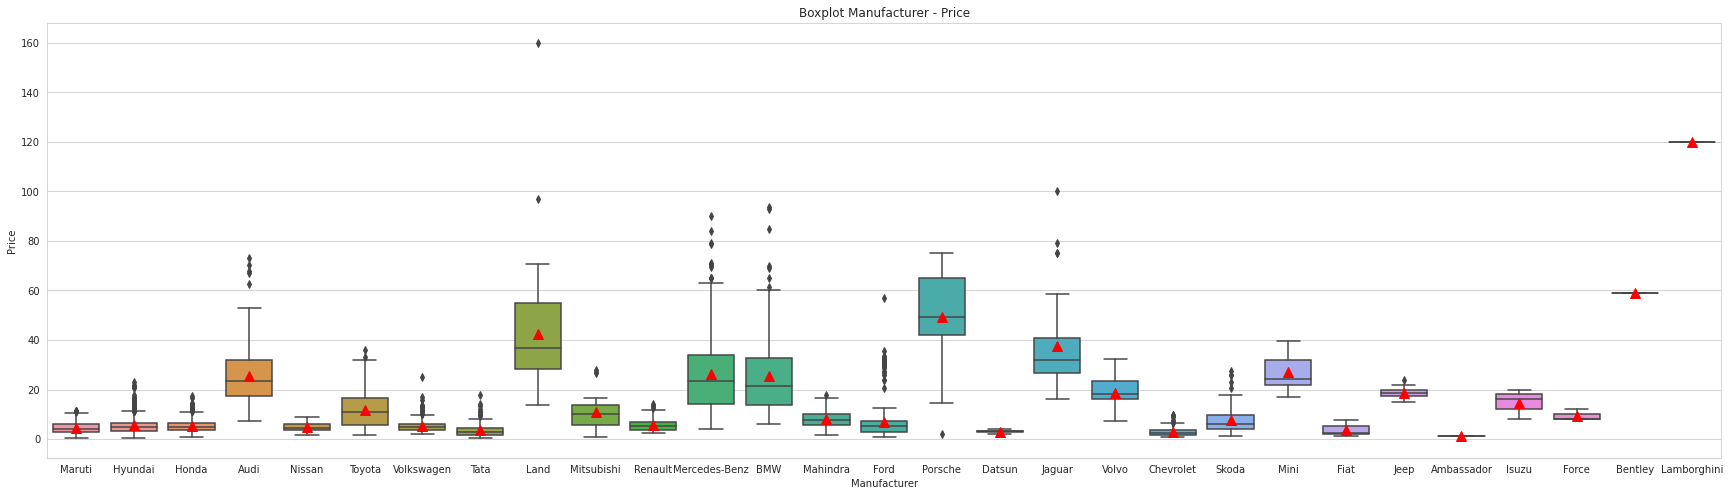

In [916]:
box_plot(df,'Manufacturer',size=(30,8))

外れ値を表示しない設定で見てみます。見やすいように"Lamborghini"も除外します。

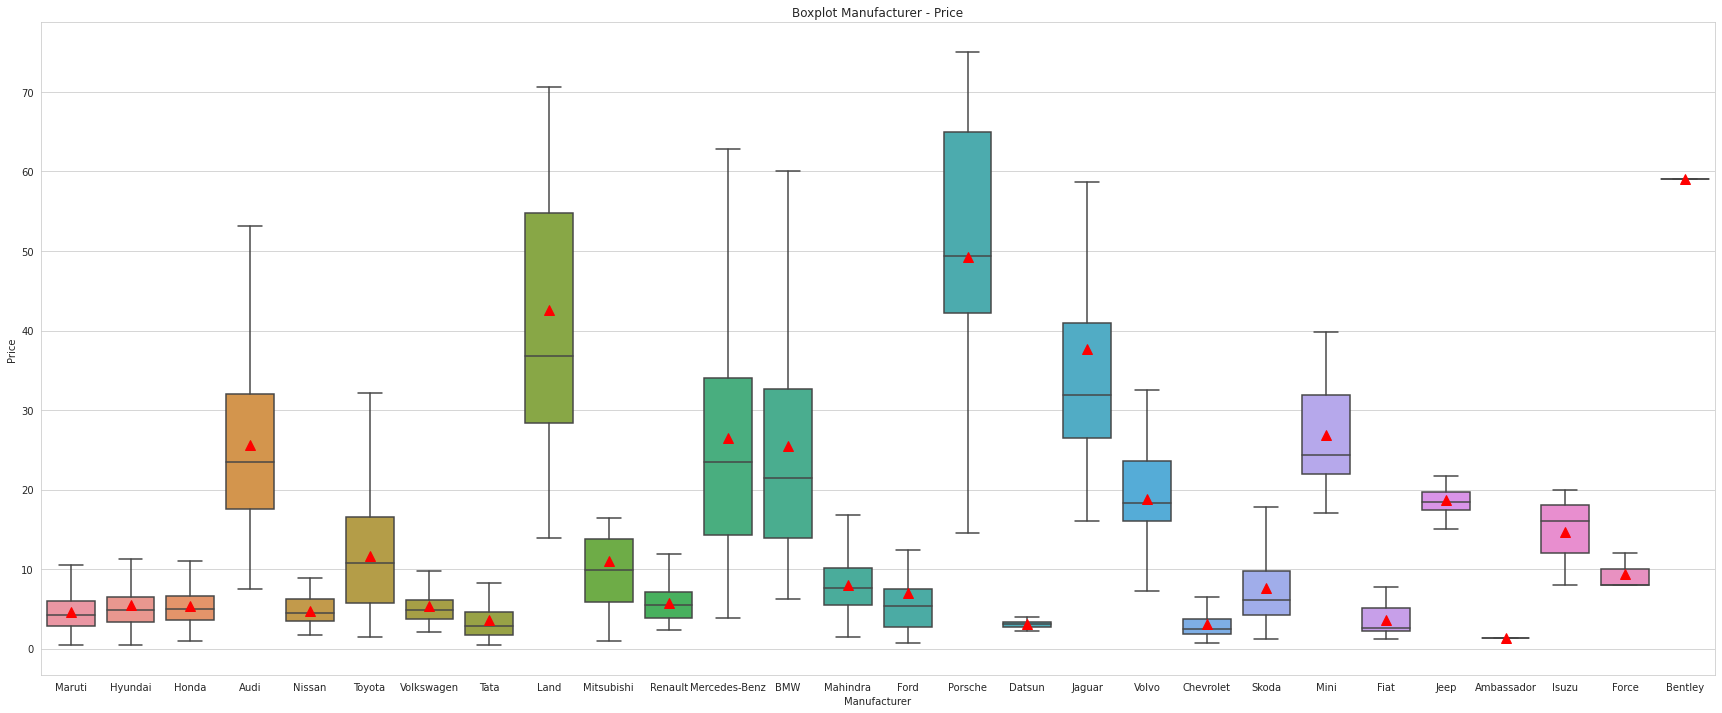

In [917]:
df_nolam=df[df['Manufacturer']!="Lamborghini"]
box_plot(df_nolam,'Manufacturer','Price',(30,12),"")

メーカーによって値の分布が違いますが、項目数が多いので、Target Encodingを用いて、各メーカーの値段の平均値によって数値化することにします。

#####'Location'について


In [918]:
df['Location'].unique()

array(['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Hyderabad', 'Jaipur',
       'Kochi', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad'],
      dtype=object)

In [919]:
df['Location'].value_counts()

Mumbai        775
Hyderabad     716
Kochi         643
Coimbatore    628
Pune          594
Delhi         546
Kolkata       523
Chennai       478
Jaipur        401
Bangalore     347
Ahmedabad     218
Name: Location, dtype: int64

'Location'ごとに値段の分布を見てみます。

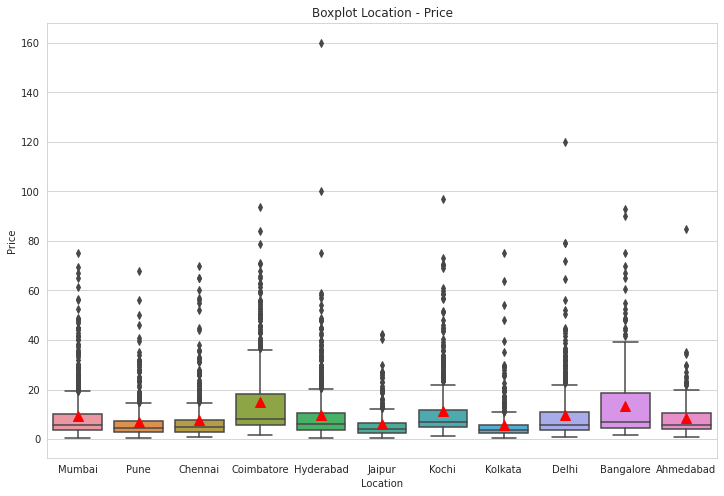

In [920]:
box_plot(df,'Location')

外れ値の存在により分布が縮小されて見づらいので、外れ値を表示しない設定にします。

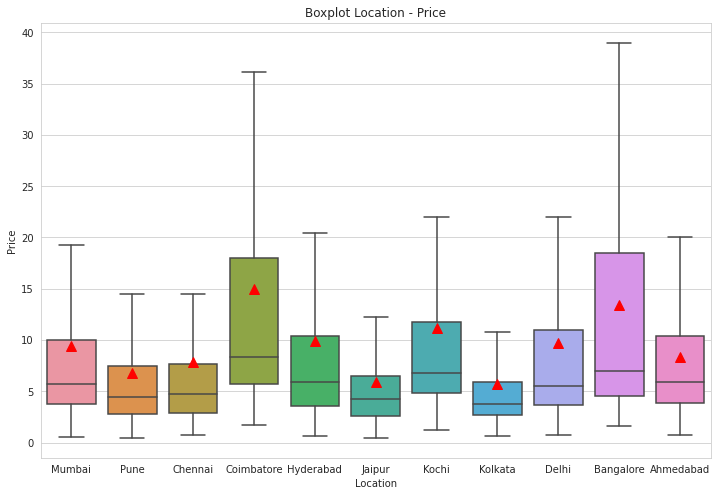

In [921]:
box_plot(df,'Location',sym="")

平均値がそれぞれの分布の違いを正当に評価しているように見えます。ですので、Target Encodingを用いて、各地域での値段の平均値によって数値化することにします。

#####'Location'と、'Name'から抽出した'Manufacturer'については、どちらもTarget Encodingをすることにしましたが、訓練データのみでエンコーディングの学習を行うことと、外れ値の影響を考えなければならないので、後に数値化の実行を行います。

#### 'Fuel_Type','Transmisson'について

どちらもカテゴリ変数なのでダミー変数に変換しようと思います。


#####'Fuel_Type'の処理

'Fuel_Type'は値の種類が多く、このままダミー変数に変換すると特徴量が増えすぎるので、項目を減らせないか考えます。

まず、'Fuel_Type'が'によって'Price'がどう変わってくるか調べるため、箱ひげ図を表示させます。

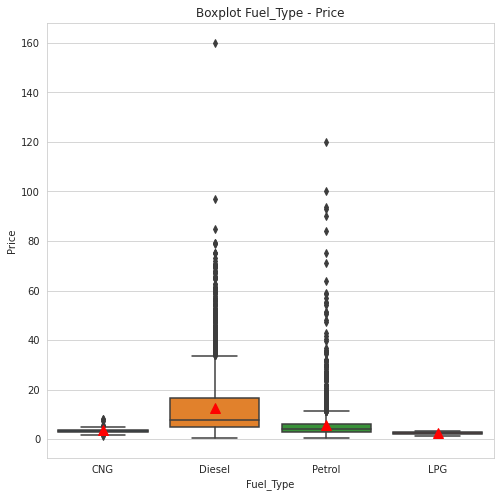

In [922]:
box_plot(df,'Fuel_Type',size=(8,8))

外れ値の存在により分布が縮小されて見づらいので、外れ値を表示しない設定にします。

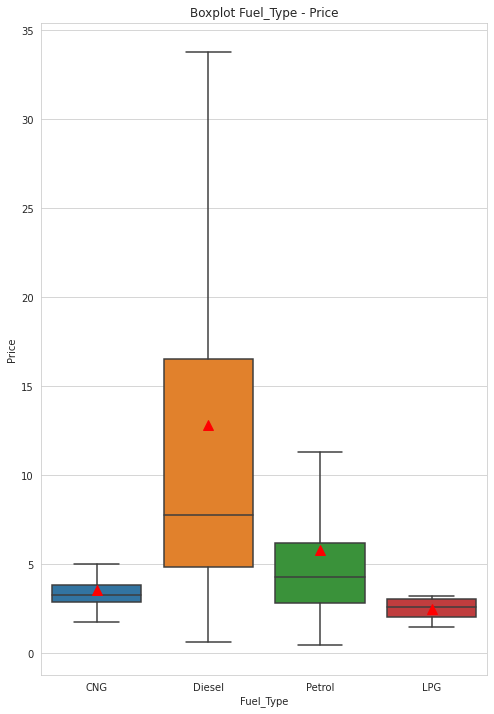

In [923]:
box_plot(df,'Fuel_Type',size=(8,12),sym="")

LPGとCNGでは分布に大差がないように見えるのでこの2つのみで確認してみます。

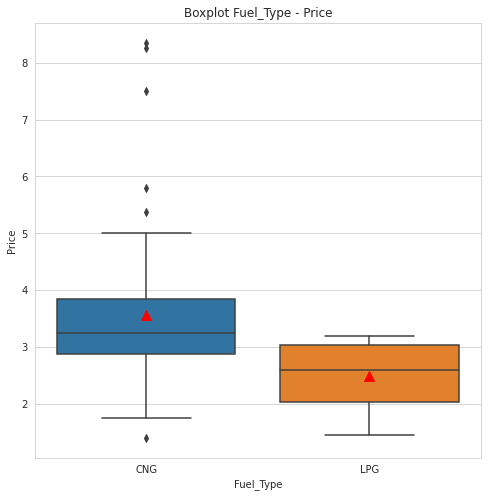

In [924]:
df_cnglpg=df[(df['Fuel_Type']=="CNG") | (df['Fuel_Type']=="LPG")]
box_plot(df_cnglpg,'Fuel_Type','Price',(8,8))

'Fuel_Type'をダミー変数に変換するときに特徴量が増えすぎるのを防ぐため、上記のように分布の差が少ないCNGとLPGはまとめます。

In [925]:
df['Fuel_Type']=df['Fuel_Type'].str.replace('CNG','CNGorLPG').replace('LPG','CNGorLPG')
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd,Manufacturer
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNGorLPG,Manual,1,998.0,58.16,5.0,1.75,17.733333,Maruti
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,1,1582.0,126.20,5.0,12.50,21.855556,Hyundai
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,1,1199.0,88.70,5.0,4.50,18.200000,Honda
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,1,1248.0,88.76,7.0,6.00,23.077778,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2,1968.0,140.80,5.0,17.74,16.888889,Audi


#####pd.get_dummiesを使って'Fuel_Type','Transmission'をダミー変数に変換した新たなデータフレームを作成し、そのデータフレームを元のデータフレームに連結します。

In [926]:
df_dum=pd.get_dummies(df[['Fuel_Type','Transmission']], drop_first=True)
df_dum.head()

,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual
0,0,0,1
1,1,0,1
2,0,1,1
3,1,0,1
4,1,0,0


In [927]:
df=pd.concat([df, df_dum],axis=1)
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd,Manufacturer,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNGorLPG,Manual,1,998.0,58.16,5.0,1.75,17.733333,Maruti,0,0,1
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,1,1582.0,126.20,5.0,12.50,21.855556,Hyundai,1,0,1
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,1,1199.0,88.70,5.0,4.50,18.200000,Honda,0,1,1
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,1,1248.0,88.76,7.0,6.00,23.077778,Maruti,1,0,1
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,2,1968.0,140.80,5.0,17.74,16.888889,Audi,1,0,0


正しく変換された列（'Fuel_Type_Diesel','Fuel_Type_Petrol','Transmission_Manual	'）が追加されているので、

不要になった'Fuel_Type','Transmission'を削除します。

In [928]:
df=df.drop(columns=['Fuel_Type','Transmission'])
df.head()

,Name,Location,Year,Kilometers_Driven,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd,Manufacturer,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,1,998.0,58.16,5.0,1.75,17.733333,Maruti,0,0,1
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,1,1582.0,126.20,5.0,12.50,21.855556,Hyundai,1,0,1
2,Honda Jazz V,Chennai,2011,46000,1,1199.0,88.70,5.0,4.50,18.200000,Honda,0,1,1
3,Maruti Ertiga VDI,Chennai,2012,87000,1,1248.0,88.76,7.0,6.00,23.077778,Maruti,1,0,1
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,2,1968.0,140.80,5.0,17.74,16.888889,Audi,1,0,0


####'Year','Kilometers_Driven'については整数型のまま扱います。'Seats','Price'についてはもとから浮動小数点型なので問題ありません。

In [929]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5869 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 5869 non-null   object 
 1   Location             5869 non-null   object 
 2   Year                 5869 non-null   int64  
 3   Kilometers_Driven    5869 non-null   int64  
 4   Owner_Type           5869 non-null   int64  
 5   Engine               5869 non-null   float64
 6   Power                5869 non-null   float64
 7   Seats                5869 non-null   float64
 8   Price                5869 non-null   float64
 9   Mileage_kmpd         5869 non-null   float64
 10  Manufacturer         5869 non-null   object 
 11  Fuel_Type_Diesel     5869 non-null   uint8  
 12  Fuel_Type_Petrol     5869 non-null   uint8  
 13  Transmission_Manual  5869 non-null   uint8  
dtypes: float64(5), int64(3), object(3), uint8(3)
memory usage: 727.4+ KB


###外れ値の除外

In [930]:
df.describe()

,Year,Kilometers_Driven,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual
count,5869.000000,5.869000e+03,5869.000000,5869.000000,5869.000000,5869.000000,5869.000000,5869.000000,5869.000000,5869.000000,5869.000000
mean,2013.474698,5.836582e+04,1.195434,1621.655137,112.959506,5.284205,9.522137,19.416616,0.537911,0.451014,0.713580
std,3.160539,9.220104e+04,0.446305,598.203558,53.768780,0.805565,11.169332,4.673542,0.498603,0.497637,0.452127
min,1998.000000,1.710000e+02,1.000000,624.000000,34.200000,2.000000,0.440000,6.400000,0.000000,0.000000,0.000000
25%,2012.000000,3.355000e+04,1.000000,1198.000000,75.000000,5.000000,3.500000,16.100000,0.000000,0.000000,0.000000
50%,2014.000000,5.261800e+04,1.000000,1493.000000,94.000000,5.000000,5.700000,18.900000,1.000000,0.000000,1.000000
75%,2016.000000,7.241100e+04,1.000000,1984.000000,138.100000,5.000000,9.990000,22.644444,1.000000,1.000000,1.000000
max,2019.000000,6.500000e+06,4.000000,5998.000000,560.000000,10.000000,160.000000,31.555556,1.000000,1.000000,1.000000


'Owner_Type','Fuel_Type_Diesel','Fuel_Type_Petrol','Transmission_Manual'については、エンコーディングした後なので問題ありません。

'Year','Engine','Power','Seats','Price','Mileage_kmpd'については、最大,最小ともに法外な値ではありませんが、

'Price'の最大値付近については、一応誤入力でないかどうか、'Manufacturer'を確認し、高級車であるかどうか確認します。

'Kilometers_Driven'については最大値が 650万km と大きすぎ、ギネス記録を超えています。

####参考文献



8.    VOLVO
  
  Blog > 全店 > Whats VOLVO

  1台の乗用車でもっとも長く走行したギネス記録を知っていますか？ (2018.04.19)

  [サイトへのリンク https://www.sweden-cars.jp/blog/...](https://www.sweden-cars.jp/blog/1%E5%8F%B0%E3%81%AE%E4%B9%97%E7%94%A8%E8%BB%8A%E3%81%A7%E3%82%82%E3%81%A3%E3%81%A8%E3%82%82%E9%95%B7%E3%81%8F%E8%B5%B0%E8%A1%8C%E3%81%97%E3%81%9F%E3%82%AE%E3%83%8D%E3%82%B9%E8%A8%98%E9%8C%B2%E3%82%92%E7%9F%A5%E3%81%A3%E3%81%A6%E3%81%84%E3%81%BE%E3%81%99%E3%81%8B%EF%BC%9F/#:~:text=1%E5%8F%B0%E3%81%AE%E4%B9%97%E7%94%A8%E8%BB%8A%E3%81%8C,%E3%81%AB%E8%AA%8D%E5%AE%9A%E3%81%95%E3%82%8C%E3%81%BE%E3%81%97%E3%81%9F%E3%80%82)


####'Price'の大きい順に並び替えて表示してみます。

In [931]:
df_price=df.sort_values('Price',ascending=False)
df_price.head(10)

,Name,Location,Year,Kilometers_Driven,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd,Manufacturer,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual
4079,Land Rover Range Rover 3.0 Diesel LWB Vogue,Hyderabad,2017,25000,1,2993.0,255.00,5.0,160.00,14.811111,Land,1,0,0
5781,Lamborghini Gallardo Coupe,Delhi,2011,6500,3,5204.0,560.00,2.0,120.00,6.400000,Lamborghini,0,1,0
5919,Jaguar F Type 5.0 V8 S,Hyderabad,2015,8000,1,5000.0,488.10,2.0,100.00,12.500000,Jaguar,0,1,0
1505,Land Rover Range Rover Sport SE,Kochi,2019,26013,1,2993.0,255.00,5.0,97.07,14.055556,Land,1,0,0
1974,BMW 7 Series 740Li,Coimbatore,2018,28060,1,2979.0,320.00,5.0,93.67,12.050000,BMW,0,1,0
1984,BMW 7 Series 740Li,Bangalore,2017,17465,1,2979.0,320.00,5.0,93.00,12.050000,BMW,0,1,0
4691,Mercedes-Benz SLK-Class 55 AMG,Bangalore,2014,3000,2,5461.0,421.00,2.0,90.00,12.000000,Mercedes-Benz,0,1,0
5535,BMW X6 xDrive 40d M Sport,Ahmedabad,2015,97003,1,2993.0,308.43,5.0,85.00,17.633333,BMW,1,0,0
2095,Mercedes-Benz SLC 43 AMG,Coimbatore,2019,2526,1,2996.0,362.07,2.0,83.96,19.000000,Mercedes-Benz,0,1,0
1885,Mercedes-Benz GLS 350d Grand Edition,Delhi,2018,6000,1,2987.0,258.00,7.0,79.00,12.222222,Mercedes-Benz,1,0,0


高級車種が並んでいるので誤入力ではないないかと思います。

'Manufacture'が"Land"になっている車ついては、"Land Rover"の"Rover"が落ちてしまった形です。"Land Rover"製でないものがないか確認します。

In [932]:
df_land=df_name_split[df_name_split[0]=="Land"]
df_land[1].value_counts()

Rover    51
Name: 1, dtype: int64

'Manufacture'が"Land"になっている車はすべて"Land Rover"製であると確認できたので、"Land"が"Land Rover"を表すものとしてそのまま使います。

In [933]:
df_kilo=df.sort_values('Kilometers_Driven',ascending=False)
df_kilo.head()

,Name,Location,Year,Kilometers_Driven,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd,Manufacturer,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual
2328,BMW X5 xDrive 30d M Sport,Chennai,2017,6500000,1,2993.0,258.0,5.0,65.0,17.744444,BMW,1,0,0
340,Skoda Octavia Ambition Plus 2.0 TDI AT,Kolkata,2013,775000,1,1968.0,141.0,5.0,7.5,21.444444,Skoda,1,0,0
1860,Volkswagen Vento Diesel Highline,Chennai,2013,720000,1,1598.0,103.6,5.0,5.9,22.822222,Volkswagen,1,0,1
358,Hyundai i10 Magna 1.2,Chennai,2009,620000,1,1197.0,78.9,5.0,2.7,20.360000,Hyundai,0,1,1
3092,Honda City i VTEC SV,Kolkata,2015,480000,1,1497.0,117.3,5.0,5.0,17.400000,Honda,0,1,1


走行距離650万kmはおそらく値段650万ルピーと混同した誤入力だと思われるのでこの行を削除します。

その下の77.5万kmについては、ありうる数字なのでそのまま使います。

####参考文献

9.   くるまのニュース
  
  クルマの走行距離の限界は？ 90万キロ超のクルマも実在!? 自動車の寿命っていったいいつ？
  
  https://kuruma-news.jp/post/235572

  [アクセス日　2021/02/02]




####外れ値を含む行の削除

In [934]:
df=df[df['Kilometers_Driven']<1000000]
df.describe()

,Year,Kilometers_Driven,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual
count,5868.000000,5868.000000,5868.000000,5868.000000,5868.000000,5868.000000,5868.000000,5868.000000,5868.000000,5868.000000,5868.000000
mean,2013.474097,57268.062713,1.195467,1621.421438,112.934789,5.284254,9.512682,19.416901,0.537832,0.451091,0.713701
std,3.160473,37798.479330,0.446336,597.986537,53.740006,0.805625,11.146773,4.673889,0.498609,0.497645,0.452069
min,1998.000000,171.000000,1.000000,624.000000,34.200000,2.000000,0.440000,6.400000,0.000000,0.000000,0.000000
25%,2012.000000,33541.750000,1.000000,1198.000000,75.000000,5.000000,3.500000,16.100000,0.000000,0.000000,0.000000
50%,2014.000000,52609.000000,1.000000,1493.000000,94.000000,5.000000,5.700000,18.900000,1.000000,0.000000,1.000000
75%,2016.000000,72402.750000,1.000000,1984.000000,138.100000,5.000000,9.990000,22.644444,1.000000,1.000000,1.000000
max,2019.000000,775000.000000,4.000000,5998.000000,560.000000,10.000000,160.000000,31.555556,1.000000,1.000000,1.000000


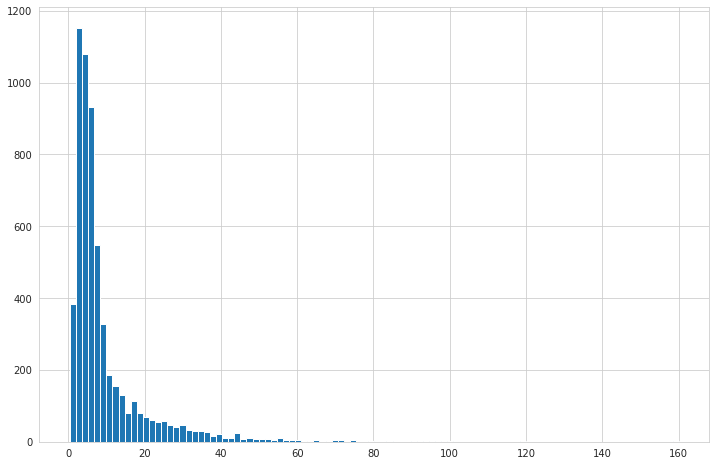

In [935]:
plt.figure(figsize=(12,8))
plt.hist(df['Price'],bins=100)
plt.show()

理想的な分布ではありませんが、今回は明らかな誤入力以外の外れ値は削除せずそのままデータとして扱ってみます。

外れ値の除外が終わりました。

##訓練データとテストデータの分割

In [936]:
df.head()

,Name,Location,Year,Kilometers_Driven,Owner_Type,Engine,Power,Seats,Price,Mileage_kmpd,Manufacturer,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,1,998.0,58.16,5.0,1.75,17.733333,Maruti,0,0,1
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,1,1582.0,126.20,5.0,12.50,21.855556,Hyundai,1,0,1
2,Honda Jazz V,Chennai,2011,46000,1,1199.0,88.70,5.0,4.50,18.200000,Honda,0,1,1
3,Maruti Ertiga VDI,Chennai,2012,87000,1,1248.0,88.76,7.0,6.00,23.077778,Maruti,1,0,1
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,2,1968.0,140.80,5.0,17.74,16.888889,Audi,1,0,0


train_test_splitを用いてランダムに訓練データとテストデータを分割します。

特徴量を持つpd.DataFrameをX、目的変数である正解ラベルを持つpd.Seriesをyとします。

In [937]:
X=df.drop(columns=['Name','Price'])
y=df['Price']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)


##'Manufacturer','Location'のTarget Encoding

後回しにしていた'Manufacturer','Location'のTarget Encodingを行います。

Leakageを避けるため、各グループ(各メーカーや各地域)内の値段の平均を訓練データから求め、それを用いて訓練データもテストデータもエンコーディングする関数を作ります。

前回のコードではテストデータに「訓練データにはないグループ（車種や地域）」が含まれていた場合エンコーディングできなかったので、その場合には訓練データ全体の'Price'の平均でエンコーディングするように変更します。

In [938]:
def target_encoder(X_train,X_test,y_train,y_test,col,label='Price'):
  train=pd.concat([X_train,y_train],axis=1)
  test=pd.concat([X_test,y_test],axis=1)   #一度特徴量と目的変数の列を連結

  train[str(col)+'_code']=train.groupby(col).transform(np.mean)[label]  #訓練データから求めた各グループの'Price'の平均で訓練データをエンコ-ディング
  agg_seri=train.groupby(col).agg(np.mean)[label]  #訓練データから求めた各グループの'Price'の平均を表にしたもの(indexはグループラベル文字列)
  print(agg_seri) #エンコーディングの際の対応表を確認

  test[str(col)+'_code']=test[col]
  na_list=[]
  
  for i in test[col].unique():
    if i in agg_seri.index:
      test[str(col)+'_code']=test[str(col)+'_code'].str.replace(i ,str(agg_seri[i]))  #訓練データから求めた各グループの平均でテストデータをエンコ-ディング
    else:
      na_list.append(i)
      test[str(col)+'_code']=test[str(col)+'_code'].str.replace(i ,str(train[label].mean()))   #テストデータに存在し、訓練データにはなかったグループには仕方ないので訓練データ全体の'Price'の平均を適用
  """
  #代替アルゴリズム
  for i in test.index:
    colstr=test.at[i,str(col)+'_code']
    if colstr in agg_seri.index:
      test.at[i,str(col)+'_code']=agg_seri[colstr]
    elif colstr in na_list:
      test.at[i,str(col)+'_code']=train[label].mean()
    else:
      na_list.append(colstr)
      test.at[i,str(col)+'_code']=train[label].mean()
  """

  test[str(col)+'_code']=test[str(col)+'_code'].astype(float)
  if len(na_list)>0:
    print(na_list,"グループは訓練データに含まれず、訓練データ全体の'"+label+"'の平均",train[label].mean()," を適用")

  X_train_re=train.drop(columns=[col,y_train.name])
  y_train_re=train[y_train.name]
  X_test_re=test.drop(columns=[col,y_test.name])
  y_test_re=test[y_test.name]
  train_re=pd.concat([X_train_re,y_train_re],axis=1)
  test_re=pd.concat([X_test_re,y_test_re],axis=1)
  X_re=pd.concat([X_train_re,X_test_re],axis=0)
  y_re=pd.concat([y_train_re,y_test_re],axis=0)
  df_re=pd.concat([X_re,y_re],axis=1)

  return df_re,X_re,y_re,train_re,test_re,X_train_re,X_test_re,y_train_re,y_test_re

  """
  #あまり意味がないので削除
  #以下は間違ったコードがないかの確認。なければ df_re,X_re,y_re,train_re,test_re,X_train_re,X_test_re,y_train_re,y_test_re を返します。
  
  print("")
  print("--------------------------------------------------")
  print("")

  df=pd.concat([train,test],axis=0)
  alert_count=[]

  for i in df[col].unique():
    df_man=df[df[col]==i]
    alert=0
    
    for j in df_man[str(col)+'_code']:
      if j != agg_seri[i]:
        alert+=1
    
    if alert>0:
      alert_count.append([i,alert])

  if alert_count==[]:
    print("問題なくエンコーディングできました。")
    return df_re,X_re,y_re,train_re,test_re,X_train_re,X_test_re,y_train_re,y_test_re
  
  else:
    print("以下のグループ内でそれぞれ間違ったコードがあります。")
    print("")
    df_alert=pd.DataFrame(alert_count, columns=['グループラベル', '間違ったコードの出現回数'])
    print(df_alert)
  """
  


'Manufacturer','Location'のTarget Encodingを実行します。

In [939]:
df,X,y,train,test,X_train,X_test,y_train,y_test=target_encoder(X_train,X_test,y_train,y_test,'Manufacturer')

Manufacturer
Ambassador         1.350000
Audi              26.154293
BMW               25.404484
Bentley           59.000000
Chevrolet          3.081553
Datsun             3.049231
Fiat               3.002143
Force             12.000000
Ford               7.232863
Honda              5.386385
Hyundai            5.563180
Isuzu             14.696667
Jaguar            37.340286
Jeep              18.824545
Lamborghini      120.000000
Land              43.118293
Mahindra           8.124455
Maruti             4.512379
Mercedes-Benz     26.765574
Mini              26.253043
Mitsubishi         9.465000
Nissan             4.937500
Porsche           49.204375
Renault            5.659826
Skoda              7.934565
Tata               3.519189
Toyota            11.864379
Volkswagen         5.117984
Volvo             19.335000
Name: Price, dtype: float64


In [940]:
df,X,y,train,test,X_train,X_test,y_train,y_test=target_encoder(X_train,X_test,y_train,y_test,'Location')

Location
Ahmedabad      8.352542
Bangalore     13.898686
Chennai        7.556005
Coimbatore    15.538733
Delhi         10.017449
Hyderabad     10.364122
Jaipur         6.058416
Kochi         10.938893
Kolkata        5.946141
Mumbai         9.603802
Pune           6.782739
Name: Price, dtype: float64


##今回は値段の範囲は絞らずに、標準化、及び主成分分析(PCA)による次元削減を行ってから、XGBoostモデルによる学習を行ってみます。

PCAの前にすべての特徴量の組み合わせの相関係数を確認してみます。

In [941]:
df.corr()

,Year,Kilometers_Driven,Owner_Type,Engine,Power,Seats,Mileage_kmpd,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual,Manufacturer_code,Location_code,Price
Year,1.000000,-0.444895,-0.386143,-0.068822,0.013626,0.008047,0.295522,0.105971,-0.107388,-0.085120,0.015168,0.236491,0.297959
Kilometers_Driven,-0.444895,1.000000,0.212357,0.161539,0.004451,0.212101,-0.078621,0.234437,-0.233824,0.105290,-0.036118,-0.112435,-0.162449
Owner_Type,-0.386143,0.212357,1.000000,0.058972,0.026396,0.011358,-0.151165,-0.040510,0.041130,0.002859,0.028697,-0.072898,-0.091774
Engine,-0.068822,0.161539,0.058972,1.000000,0.866269,0.406757,-0.517795,0.427209,-0.407930,-0.497808,0.652347,0.125358,0.657228
Power,0.013626,0.004451,0.026396,0.866269,1.000000,0.103572,-0.452961,0.288024,-0.268341,-0.644079,0.775015,0.159657,0.774956
Seats,0.008047,0.212101,0.011358,0.406757,0.103572,1.000000,-0.279170,0.309283,-0.302878,0.072328,-0.012856,0.029013,0.058848
Mileage_kmpd,0.295522,-0.078621,-0.151165,-0.517795,-0.452961,-0.279170,1.000000,0.338055,-0.329137,0.314010,-0.318484,-0.069981,-0.252056
Fuel_Type_Diesel,0.105971,0.234437,-0.040510,0.427209,0.288024,0.309283,0.338055,1.000000,-0.977924,-0.133420,0.305600,0.038881,0.316109
Fuel_Type_Petrol,-0.107388,-0.233824,0.041130,-0.407930,-0.268341,-0.302878,-0.329137,-0.977924,1.000000,0.119579,-0.293796,-0.034647,-0.304502
Transmission_Manual,-0.085120,0.105290,0.002859,-0.497808,-0.644079,0.072328,0.314010,-0.133420,0.119579,1.000000,-0.650748,-0.156387,-0.583535


ヒートマップで表示してみます。

In [942]:
def heat(cor,xlabels='auto',ylabels='auto',size=(10,8),annotsize=10):
  plt.figure(figsize=size)
  sns.heatmap(cor,
              cmap="Blues",
              annot=True,
              annot_kws={"size":annotsize},
              fmt="1.2f",
              xticklabels=xlabels,
              yticklabels=ylabels)

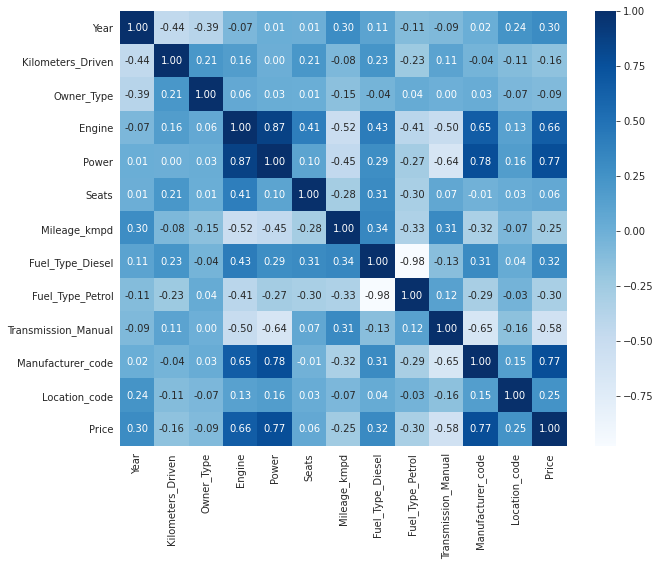

In [943]:
heat(df.corr())

特徴量同士の相関が強いところもあります。PCAが有効でしょう。

各相関関係は、値段を絞った時と比べてそれほど変わりません。高級車たちの影響をほとんど受けていないか、高級車たちも特徴量の傾向は変わらないことがわかります。

##標準化

In [944]:
X_train.head()

,Year,Kilometers_Driven,Owner_Type,Engine,Power,Seats,Mileage_kmpd,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual,Manufacturer_code,Location_code
1471,2015,22000,1,1198.0,74.0,5.0,16.470000,0,1,1,5.117984,5.946141
3674,2016,42225,1,1196.0,73.0,7.0,15.100000,0,1,1,4.512379,15.538733
1303,2012,44450,1,1995.0,190.0,5.0,24.977778,1,0,0,25.404484,15.538733
893,2010,95637,2,1495.0,93.7,5.0,8.800000,0,0,1,5.563180,10.364122
4506,2016,6714,1,1198.0,86.7,5.0,18.000000,0,1,1,5.386385,6.058416


PCAの前にsklearnのStandardScalerを用いて特徴量の標準化を行います。

戻り値はndarryなので、データフレームに入れ直し、もとの列名を付けます。シャッフル前の行名(番号)は失われ、X_train,X_testともに0から順番通りの行番号が行名になってしまいます。

In [945]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

X_train_std=sc.fit_transform(X_train)
X_test_std=sc.transform(X_test)
X_train_std=pd.DataFrame(X_train_std,columns=X_train.columns)
X_test_std=pd.DataFrame(X_test_std,columns=X_test.columns)

In [946]:
X_train_std.head()

,Year,Kilometers_Driven,Owner_Type,Engine,Power,Seats,Mileage_kmpd,Fuel_Type_Diesel,Fuel_Type_Petrol,Transmission_Manual,Manufacturer_code,Location_code
0,0.482258,-0.917954,-0.435322,-0.707105,-0.722584,-0.351185,-0.626402,-1.076640,1.099991,0.635711,-0.515975,-1.300058
1,0.801316,-0.391204,-0.435322,-0.710402,-0.740775,2.111043,-0.920655,-1.076640,1.099991,0.635711,-0.584059,2.015462
2,-0.474917,-0.333255,-0.435322,0.606842,1.387618,-0.351185,1.200922,0.928816,-0.909098,-1.573043,1.764718,2.015462
3,-1.113033,0.999884,1.795466,-0.217466,-0.364213,-0.351185,-2.273786,-1.076640,-0.909098,0.635711,-0.465924,0.226943
4,0.801316,-1.316070,-0.435322,-0.707105,-0.491553,-0.351185,-0.297784,-1.076640,1.099991,0.635711,-0.485800,-1.261252


もとのデータフレームと見比べて、正しく標準化できているであろうことが確認できます。

##主成分分析

sklearnのPCAを用いて主成分分析を行います。


In [947]:
from sklearn.decomposition import PCA
pca=PCA()

PCAメソッドも戻り値はndarryなので、データフレームに入れ直し、各主成分に対応してPC1～PC12の列名を付けます。

In [948]:
X_train_pca=pca.fit_transform(X_train_std)
X_test_pca=pca.transform(X_test_std)

ord12=["PC"+str(i) for i in range(1,13)]

X_train_pca=pd.DataFrame(X_train_pca,columns=ord12)
X_test_pca=pd.DataFrame(X_test_pca,columns=ord12)
X_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-1.893166,1.044035,-0.458727,-0.352360,-1.393634,-0.491229,0.021435,0.255683,0.103699,-0.508482,-0.029530,-0.063142
1,-1.081652,0.806898,-0.611358,-3.097589,1.336378,0.015469,0.183027,-0.490335,0.739101,0.153433,0.312230,-0.037487
2,2.631307,-0.521962,-1.491759,1.157390,1.426798,0.806703,-0.738873,-0.691558,0.384589,1.040877,0.130611,0.071527
3,-0.205607,1.368652,2.310398,-0.061714,1.090317,-0.231689,-0.083209,0.270885,-0.279532,-1.798105,0.392982,1.244291
4,-1.866718,0.913542,-0.936616,-0.318348,-1.408014,-0.786565,-0.008617,0.378265,0.061891,-0.256156,0.058764,-0.047611


In [949]:
print(X_train_pca.shape,y_train.shape)
print(X_test_pca.shape,y_test.shape)

(4694, 12) (4694,)
(1174, 12) (1174,)


当たり前ですが、値段を絞った時より行数が多いことがわかります。

今後の操作における利便化のため、改めて訓練データ全体、テストデータ全体、特徴量データ全体、正解ラベルデータ全体、全体のデータを表すデータフレームを作ります。

標準化とPCAの操作によってX_train,X_testはシャッフルされる前のもとの行名を保持せずにX_train,X_testともに0から順番通りの行番号が行名になってしまっており、y_train,y_testの行名が一致しない、訓練データとテストデータをつなげると行名が重複してしまうなどの不都合があるので、新しく訓練データ,テストデータの順に0～の行名をつけなおします。列名は変更しません。

In [950]:
def concat(X_train,X_test,y_train,y_test):
  list_df=[[X_train,X_test],[y_train,y_test]]
  for xy in list_df:
    xy[0].index=[i for i in range(0,xy[0].shape[0])]
    xy[1].index=[i for i in range(xy[0].shape[0],(xy[0].shape[0]+xy[1].shape[0]))]
  train_re=pd.concat([X_train,y_train],axis=1)
  test_re=pd.concat([X_test,y_test],axis=1)
  X_re=pd.concat([X_train,X_test],axis=0)
  y_re=pd.concat([y_train,y_test],axis=0)
  df_re=pd.concat([X_re,y_re],axis=1)
  return X_train,X_test,y_train,y_test,train_re,test_re,X_re,y_re,df_re

In [951]:
X_train_pca,X_test_pca,y_train_pca,y_test_pca,train_pca,test_pca,X_pca,y_pca,df_pca=concat(X_train_pca,X_test_pca,y_train,y_test)

In [952]:
train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Price
0,-1.893166,1.044035,-0.458727,-0.352360,-1.393634,-0.491229,0.021435,0.255683,0.103699,-0.508482,-0.029530,-0.063142,3.80
1,-1.081652,0.806898,-0.611358,-3.097589,1.336378,0.015469,0.183027,-0.490335,0.739101,0.153433,0.312230,-0.037487,4.30
2,2.631307,-0.521962,-1.491759,1.157390,1.426798,0.806703,-0.738873,-0.691558,0.384589,1.040877,0.130611,0.071527,24.68
3,-0.205607,1.368652,2.310398,-0.061714,1.090317,-0.231689,-0.083209,0.270885,-0.279532,-1.798105,0.392982,1.244291,1.90
4,-1.866718,0.913542,-0.936616,-0.318348,-1.408014,-0.786565,-0.008617,0.378265,0.061891,-0.256156,0.058764,-0.047611,4.75


In [953]:
test_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Price
4694,-1.070443,1.059106,-0.440482,-0.676755,0.148799,0.588701,0.265432,0.774995,-0.156483,0.062102,0.096138,-0.017642,6.57
4695,-1.652179,1.493941,0.140846,0.201725,-0.300828,0.105574,-2.066851,-0.678686,0.129460,0.564583,0.145156,0.003356,6.00
4696,-1.694763,1.404444,0.650770,0.043958,-1.330602,0.146433,-0.725573,-0.124425,0.048151,-0.150531,0.202749,-0.052001,1.99
4697,-0.556118,-2.382329,-0.877984,0.434613,0.468178,0.115934,-0.072370,0.424215,-0.250024,0.551721,-0.150572,0.037890,7.52
4698,-0.223749,-1.701230,0.560528,0.883335,-1.045190,0.138756,-0.518455,0.328095,-0.458064,0.327457,0.237443,-0.004042,5.75


寄与率を表示します。

In [954]:
pca.explained_variance_ratio_

array([0.31414543, 0.18154704, 0.16092308, 0.09664225, 0.07468963,
       0.05967141, 0.03785306, 0.0313043 , 0.02073782, 0.01577717,
       0.0050488 , 0.00166001])

累積寄与率を表示します。

In [955]:
pca.explained_variance_ratio_.cumsum()

array([0.31414543, 0.49569247, 0.65661555, 0.75325781, 0.82794743,
       0.88761884, 0.9254719 , 0.9567762 , 0.97751402, 0.99329119,
       0.99833999, 1.        ])

寄与率も、値段を絞った時に比べてあまり変わりません。

累積寄与率は80%を目安として、第5主成分まで残したいと思います。

その前に、各主成分の固有ベクトルと'Price'との相関関係をわかりやすくヒートマップで確認します。

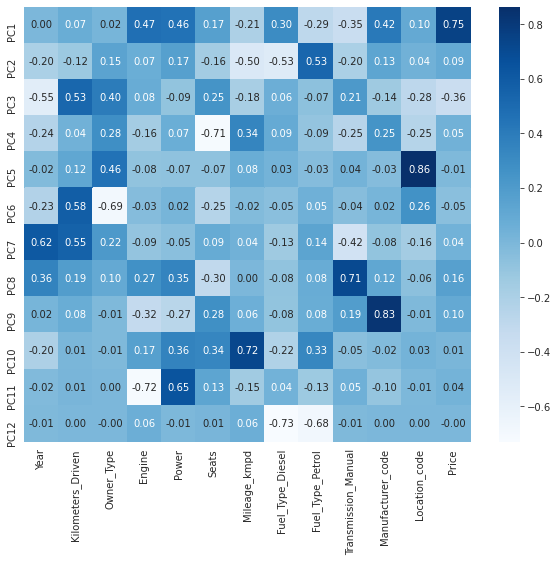

In [956]:
comp=pd.DataFrame(pca.components_,index=ord12,columns=X.columns)
compcorr=pd.concat([comp,df_pca.corr()['Price'][0:12]],axis=1)
heat(compcorr)

こちらも値段を絞った時と比べて、各特徴量間の相関関係がほとんど変わらなかったので、固有ベクトルのほうもほとんど変わりません。

PC1は排気量,馬力,メーカーを、

PC2は燃費,燃料の種類を、

PC3はモデルの年,総走行距離,前オーナー数を、

PC4は席数,トランスミッションを、

PC5は地域を、

比較的重視した主成分と見て取れます。

同じ主成分に対して大きく寄与している特徴量どうしは大抵もともと相関のあったものであることがdf.corr()のヒートマップを見るとわかります。

また、第1～5主成分の'Price'との相関も悪くないです。

試しに第1～3主成分のうち２つと'Price'の関係をグラフにしてみます。
縦横軸は主成分、カラーマップは'Price'を表します。

カラーマップを表示すると高級車が飛び抜けている分わかりずらいので使う色を変更しました。

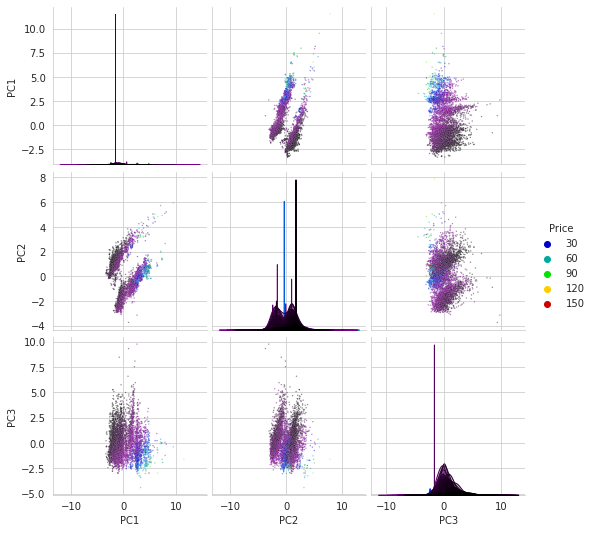

In [957]:
import warnings
warnings.simplefilter('ignore')

sns.pairplot(df_pca.drop(columns=["PC"+str(i) for i in range(4,13)]),plot_kws={'s':2,'alpha': 0.5}, hue='Price', palette='nipy_spectral')

それぞれ'Price'との相関関係が見て取れます。

##次元削減

先程累積寄与率で確認した通り、第1～5主成分を残し、残りを削除します。

In [958]:
X_train_rd=X_train_pca.drop(columns=["PC"+str(i) for i in range(6,13)])
X_test_rd=X_test_pca.drop(columns=["PC"+str(i) for i in range(6,13)])

改めて訓練データ全体、テストデータ全体、特徴量データ全体、正解ラベルデータ全体、全体のデータを表すデータフレームを作ります。

In [959]:
X_train,X_test,y_train,y_test,train,test,X,y,df=concat(X_train_rd,X_test_rd,y_train_pca,y_test_pca)

##モデル構築

###データ構造の確認

In [960]:
train.head()

,PC1,PC2,PC3,PC4,PC5,Price
0,-1.893166,1.044035,-0.458727,-0.352360,-1.393634,3.80
1,-1.081652,0.806898,-0.611358,-3.097589,1.336378,4.30
2,2.631307,-0.521962,-1.491759,1.157390,1.426798,24.68
3,-0.205607,1.368652,2.310398,-0.061714,1.090317,1.90
4,-1.866718,0.913542,-0.936616,-0.318348,-1.408014,4.75


In [961]:
test.head()

,PC1,PC2,PC3,PC4,PC5,Price
4694,-1.070443,1.059106,-0.440482,-0.676755,0.148799,6.57
4695,-1.652179,1.493941,0.140846,0.201725,-0.300828,6.00
4696,-1.694763,1.404444,0.650770,0.043958,-1.330602,1.99
4697,-0.556118,-2.382329,-0.877984,0.434613,0.468178,7.52
4698,-0.223749,-1.701230,0.560528,0.883335,-1.045190,5.75


In [962]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4694 entries, 0 to 4693
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     4694 non-null   float64
 1   PC2     4694 non-null   float64
 2   PC3     4694 non-null   float64
 3   PC4     4694 non-null   float64
 4   PC5     4694 non-null   float64
 5   Price   4694 non-null   float64
dtypes: float64(6)
memory usage: 256.7 KB


In [963]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1174 entries, 4694 to 5867
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     1174 non-null   float64
 1   PC2     1174 non-null   float64
 2   PC3     1174 non-null   float64
 3   PC4     1174 non-null   float64
 4   PC5     1174 non-null   float64
 5   Price   1174 non-null   float64
dtypes: float64(6)
memory usage: 64.2 KB


値段を絞らず、次元を削減したこの状態で、XGBoostの学習を行います。

###モデルの学習

特徴量X_trainと目的変数y_trainを用いて学習を行います。

引数max_depthの値の決定については後述のmax_depthとMAE,MAPEのグラフを参考にしています。

In [964]:
import xgboost

xgb=xgboost.XGBRegressor(max_depth=9) 

xgb.fit(X_train,y_train)

[06:27:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

###モデルの推論と検証

学習したモデルを用いて推論を行い、平均絶対誤差(MAE)を表示させます。

In [965]:
from sklearn.metrics import mean_absolute_error

y_train_pred=xgb.predict(X_train)
print('trainMAE',mean_absolute_error(y_train,y_train_pred))
y_test_pred=xgb.predict(X_test)
print('testMAE',mean_absolute_error(y_test,y_test_pred))


trainMAE 0.46931246846774605
testMAE 1.6990046584870175


テストデータにおいて平均して17万ルピーほどの誤差が出ています。

値段を絞らず次元削減をしなかったXGBoostの場合(11万)に比べて劣っています。

In [966]:
print('trainMAPE',np.mean(np.abs((y_train_pred - y_train) / y_train)) * 100)
print('testMAPE',np.mean(np.abs((y_test_pred - y_test) / y_test)) * 100)

trainMAPE 8.800616260013223
testMAPE 21.99210707168393


MAPEのほうも値段を絞らず次元削減をしなかったXGBoostの場合(13%)に比べて劣っています。

残差プロットを表示させます。灰色の線は補助線です

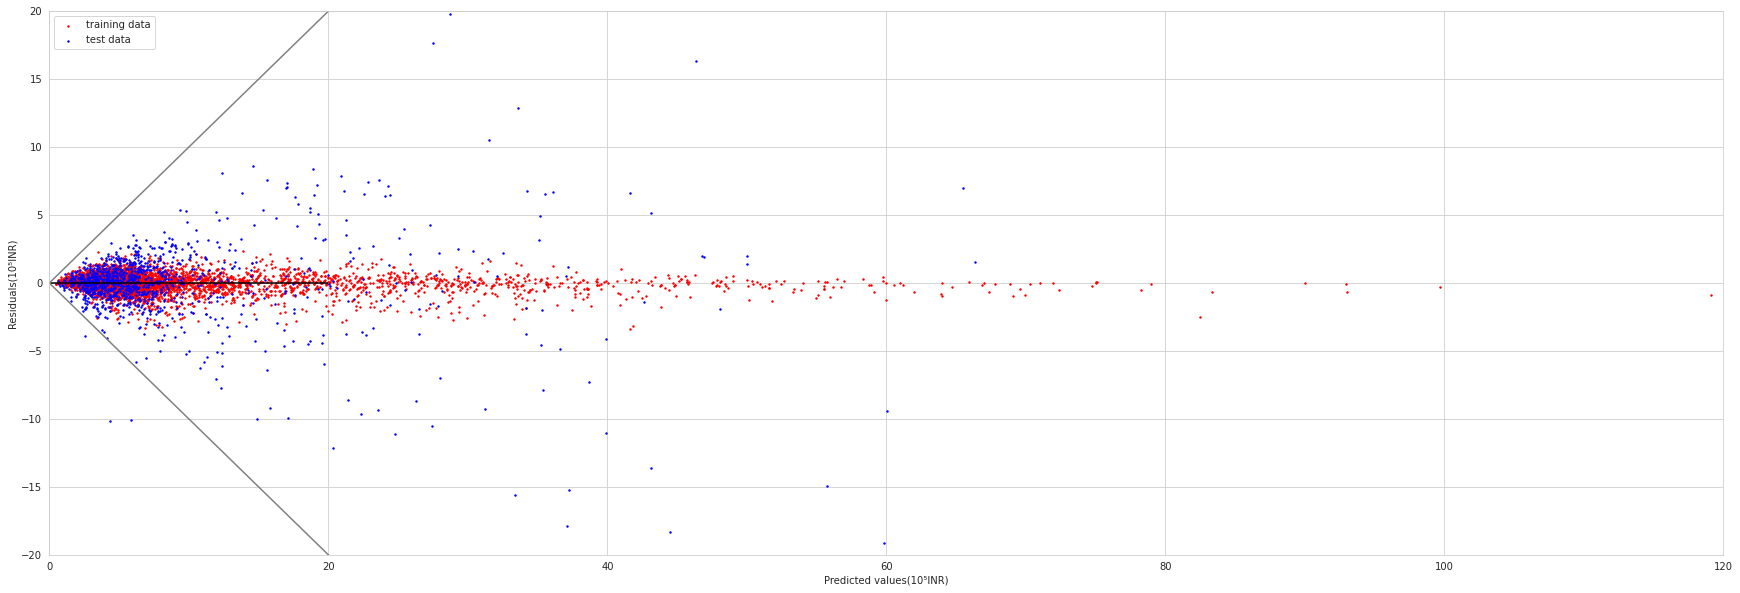

In [967]:
plt.figure(figsize=(30,10))
plt.scatter(y_train_pred,(y_train_pred-y_train),c='red',label='training data',s=2)
plt.scatter(y_test_pred,(y_test_pred-y_test),c='blue',label='test data',s=2)
plt.hlines(y=0,xmin=0,xmax=20,color='black') 
x1=np.linspace(0, 20, 100)
x2=np.linspace(0, 30, 100)
plt.plot(x1, x1,c="gray")
plt.plot(x2, -x2,c="gray")
plt.legend(loc='upper left')                                                                     
plt.xlabel('Predicted values(10⁵INR)')
plt.ylabel('Residuals(10⁵INR)')
plt.ylim(-20,20)
plt.xlim(0,120)
plt.show()

同じ領域で分かりやすく比べるために、高級車を除外しなかったときに値段の低い領域のみ表示したときと同じ領域を表示してみます。

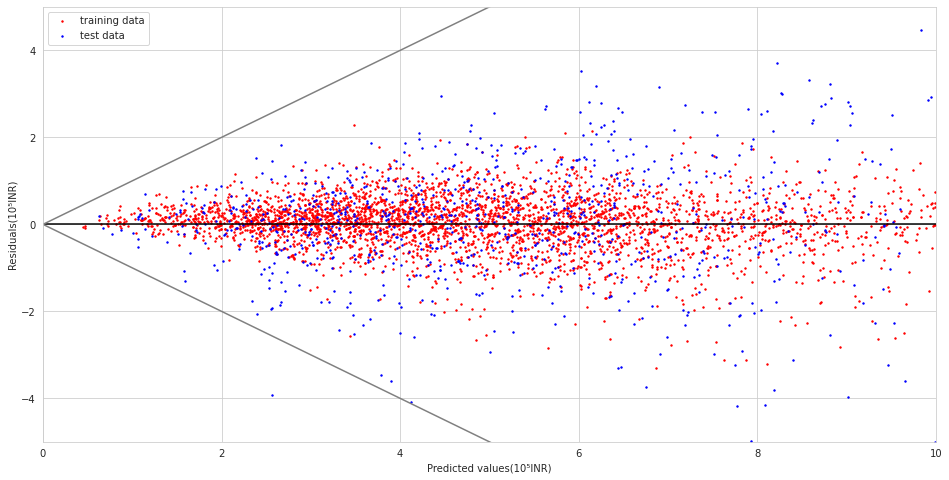

In [968]:
plt.figure(figsize=(16,8))
plt.scatter(y_train_pred,(y_train_pred-y_train),c='red',label='training data',s=2)
plt.scatter(y_test_pred,(y_test_pred-y_test),c='blue',label='test data',s=2)
plt.hlines(y=0,xmin=0,xmax=100,color='black') 
x1=np.linspace(0, 20, 100)
x2=np.linspace(0, 30, 100)
plt.plot(x1, x1,c="gray")
plt.plot(x2, -x2,c="gray")
plt.legend(loc='upper left')                                                                     
plt.xlabel('Predicted values(10⁵INR)')
plt.ylabel('Residuals(10⁵INR)')
plt.xlim(0,10)
plt.ylim(-5,5)
plt.show()

残差プロットが無相関である、つまり系統誤差が見られないので、良い結果です。

ただやはり、値段を絞らず次元削減をしなかったXGBoostの場合に比べて誤差が大きくなっているのがわかります。


引数max_depthとMAE,MAPEの関係をグラフにしてみます。

[06:28:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

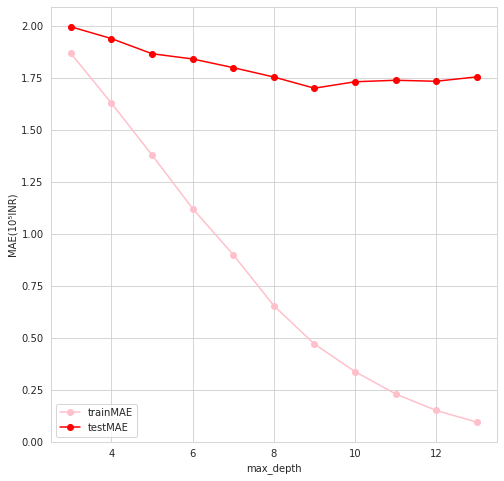

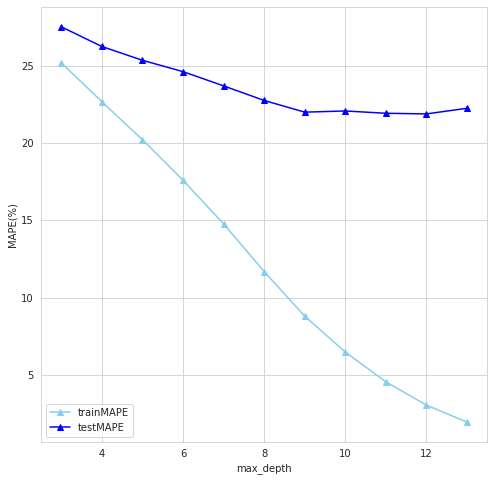

In [969]:
max=14
trainMAE=[]
testMAE=[]
trainMAPE=[]
testMAPE=[]
for i in range(3,max):
  xgb_gra=xgboost.XGBRegressor(max_depth=i) 
  xgb_gra.fit(X_train,y_train)
  y_train_pred_gra=xgb_gra.predict(X_train)
  y_test_pred_gra=xgb_gra.predict(X_test)
  trainMAE.append(mean_absolute_error(y_train,y_train_pred_gra))
  testMAE.append(mean_absolute_error(y_test,y_test_pred_gra))
  trainMAPE.append(np.mean(np.abs((y_train_pred_gra - y_train) / y_train)) * 100)
  testMAPE.append(np.mean(np.abs((y_test_pred_gra - y_test) / y_test)) * 100)
plt.figure(figsize=(8,8))
plt.plot(np.arange(3,max), np.array(trainMAE),marker="o",color="pink",label='trainMAE')
plt.plot(np.arange(3,max), np.array(testMAE),marker="o",color="red",label='testMAE')
plt.legend(loc='lower left')                                                                     
plt.xlabel('max_depth')
plt.ylabel('MAE(10⁵INR)')
plt.show()

plt.figure(figsize=(8,8))
plt.plot(np.arange(3,max), np.array(trainMAPE),marker="^",color="skyblue",label='trainMAPE')
plt.plot(np.arange(3,max), np.array(testMAPE),marker="^",color="blue",label='testMAPE')
plt.legend(loc='lower left')                                                                     
plt.xlabel('max_depth')
plt.ylabel('MAPE(%)')
plt.show()



MAEとMAPEを最小にするにはmax_depth=9が適正だと考えられます。

結果として、値段を絞らなかったにもかかわらず、精度(MAEなど)は線形回帰の場合と比べても決して悪くありませんが、

値段を絞らず次元削減をしなかったXGBoostの場合に比べると、学習にかかる計算コストが減った分精度が劣っています。